In [2]:
%load_ext cython
%matplotlib_svg
import pylab as pl
import numpy as np

## 分形

### Mandelbrot集合

#### 纯Python实现

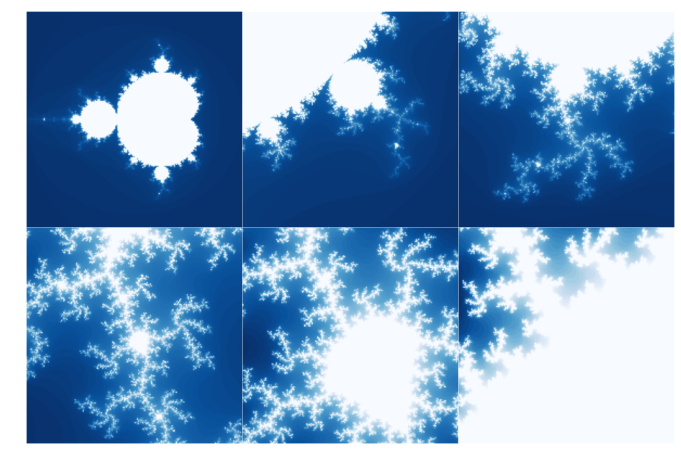

In [35]:
#%fig=Mandelbrot集合，以5倍的倍率放大点(0.273, 0.595)附近
from matplotlib import cm

def iter_point(c): #❶
    z = c
    for i in range(1, 100): # 最多迭代100次
        if abs(z) > 2: break # 半径大于2则认为逃逸
        z = z * z + c
    return i # 返回迭代次数
    
def mandelbrot(cx, cy, d, n=200):
    x0, x1, y0, y1 = cx-d, cx+d, cy-d, cy+d 
    y, x = np.ogrid[y0:y1:n*1j, x0:x1:n*1j]
    c = x + y*1j #❸
    return np.frompyfunc(iter_point,1,1)(c).astype(np.float) #❹
    
def draw_mandelbrot(cx, cy, d, n=200): #❷
    """
    绘制点(cx, cy)附近正负d的范围的Mandelbrot
    """
    pl.imshow(mandelbrot(cx, cy, d, n), cmap=cm.Blues_r)   #❺
    pl.gca().set_axis_off()
    
x, y = 0.27322626, 0.595153338

pl.figure(figsize=(9, 6))
pl.subplot(231)
draw_mandelbrot(-0.5, 0, 1.5)
for i in range(2,7):    
    pl.subplot(230+i)
    draw_mandelbrot(x, y, 0.2**(i-1))
pl.subplots_adjust(0, 0, 1, 1, 0.0, 0)

#### 用Cython提速

In [19]:
%timeit mandelbrot(-0.5, 0, 1.5)

1 loops, best of 3: 398 ms per loop


In [27]:
%%cython
def iter_point(complex c):
    cdef complex z = c
    cdef int i
    for i in range(1, 100):
        if z.real*z.real + z.imag*z.imag > 4: break #❶
        z = z * z + c
    return i

In [28]:
%timeit mandelbrot(-0.5, 0, 1.5)

100 loops, best of 3: 8.89 ms per loop


#### 连续的逃逸时间

In [37]:
%%cython
from libc.math cimport log2

def iter_point(complex c):
    cdef complex z = c
    cdef int i
    cdef double r2, mu
    for i in range(1, 20):
        r2 = z.real*z.real + z.imag*z.imag
        if r2 > 100: break 
        z = z * z + c
    if r2 > 4.0:
        mu = i - log2(0.5 * log2(r2))
    else:
        mu = i
    return mu

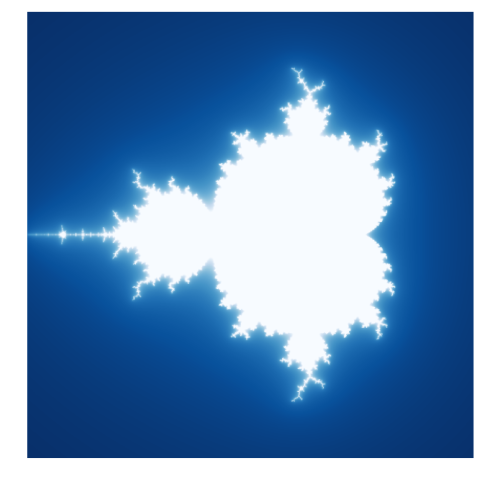

In [39]:
#%fig=平滑处理后的Mandelbrot集合：逃逸半径=10，最大迭代次数=20
pl.figure(figsize=(8, 8))
draw_mandelbrot(-0.5, 0, 1.5, n=600)

#### Mandelbrot演示程序

> **SOURCE**

> `scpy2.examples.fractal.mandelbrot_demo`：使用TraitsUI和matplotlib实时绘制Mandelbrot图像，按住鼠标左键进行平移，使用鼠标滚轴进行缩放。

In [3]:
#%hide
%exec_python -m scpy2.examples.fractal.mandelbrot_demo

In [4]:
%%include cython examples/fractal/fastfractal.pyx 1
from libc.math cimport log2
import numpy as np
import cython

cdef double iter_point(complex c, int n, double R):
    cdef complex z = c
    cdef int i
    cdef double r2, mu
    cdef double R2 = R*R
    for i in range(1, n):
        r2 = z.real*z.real + z.imag*z.imag
        if r2 > R2: break 
        z = z * z + c
    if r2 > 4.0:
        mu = i - log2(0.5 * log2(r2))
    else:
        mu = i
    return mu

def mandelbrot(double cx, double cy, double d, int h=0, int w=0, 
               double[:, ::1] out=None, int n=20, double R=10.0):
    cdef double x0, x1, y0, y1, dx, dy
    cdef double[:, ::1] r 
    cdef int i, j
    cdef complex z
    x0, x1, y0, y1 = cx - d, cx + d, cy - d, cy + d
    if out is not None:
        r = out
    else:
        r = np.zeros((h, w))
    h, w = r.shape[0], r.shape[1]
    dx = (x1 - x0) / (w - 1)
    dy = (y1 - y0) / (h - 1)
    for i in range(h):
        for j in range(w):
            z.imag = y0 + i * dy
            z.real = x0 + j * dx
            r[i, j] = iter_point(z, n, R)
    return r.base

### 迭代函数系统

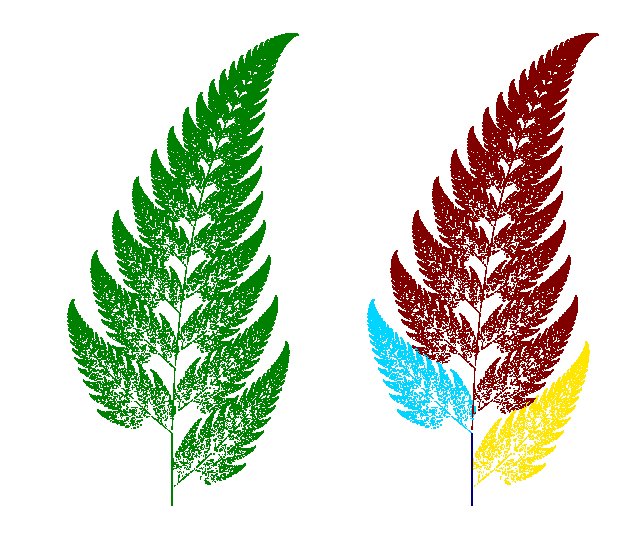

In [28]:
#%fig=函数迭代系统所绘制的蕨类植物的叶子
%config InlineBackend.figure_format = 'png'
eq1 = np.array([[0,0,0],[0,0.16,0]])
p1 = 0.01

eq2 = np.array([[0.2,-0.26,0],[0.23,0.22,1.6]])
p2 = 0.07

eq3 = np.array([[-0.15, 0.28, 0],[0.26,0.24,0.44]])
p3 = 0.07

eq4 = np.array([[0.85, 0.04, 0],[-0.04, 0.85, 1.6]])
p4 = 0.85

def ifs(p, eq, init, n):
    """
    进行函数迭代
    p: 每个函数的选择概率列表
    eq: 迭代函数列表
    init: 迭代初始点
    n: 迭代次数
    
    返回值： 每次迭代所得的X坐标数组， Y坐标数组， 计算所用的函数下标    
    """

    # 迭代向量的初始化
    pos = np.ones(3, dtype=np.float) #❶
    pos[:2] = init
    
    # 通过函数概率，计算函数的选择序列
    p = np.cumsum(p)    
    rands = np.random.rand(n)
    select = np.searchsorted(p, rands) #❷
    
    # 结果的初始化
    result = np.zeros((n,2), dtype=np.float)
    c = np.zeros(n, dtype=np.float)
    
    for i in xrange(n):
        eqidx = select[i] # 所选的函数下标
        tmp = np.dot(eq[eqidx], pos) # 进行迭代
        pos[:2] = tmp # 更新迭代向量

        # 保存结果
        result[i] = tmp
        c[i] = eqidx
        
    return result[:,0], result[:, 1], c

x, y, c = ifs([p1,p2,p3,p4], [eq1,eq2,eq3,eq4], [0,0], 100000)
fig, axes = pl.subplots(1, 2, figsize=(6, 5))
axes[0].scatter(x, y, s=1, c="g", marker="s", linewidths=0) #❸
axes[1].scatter(x, y, s=1, c=c, marker="s", linewidths=0)  #❹
for ax in axes:
    ax.set_aspect("equal")
    ax.set_ylim(0, 10.5)
    ax.axis("off")
pl.subplots_adjust(left=0,right=1,bottom=0,top=1,wspace=0,hspace=0)

#### 2D仿射变换

#### 迭代函数系统设计器

> **SOURCE**

> `scpy2.examples.fractal.ifs_demo`：迭代函数分形系统的演示程序，通过修改左侧三角形的顶点实时地计算坐标变换矩阵，并在右侧显示迭代结果。

In [5]:
#%hide
%exec_python -m scpy2.examples.fractal.ifs_demo

In [1]:
%%include python examples/fractal/ifs_demo.py 1
def solve_eq(triangle1, triangle2):
    """
    解方程，从triangle1变换到triangle2的变换系数
        triangle1,2是二维数组：
        x0,y0
        x1,y1
        x2,y2
    """
    x0, y0 = triangle1[0]
    x1, y1 = triangle1[1]
    x2, y2 = triangle1[2]

    a = np.zeros((6, 6), dtype=np.float)
    b = triangle2.reshape(-1)
    a[0, 0:3] = x0, y0, 1
    a[1, 3:6] = x0, y0, 1
    a[2, 0:3] = x1, y1, 1
    a[3, 3:6] = x1, y1, 1
    a[4, 0:3] = x2, y2, 1
    a[5, 3:6] = x2, y2, 1

    x = np.linalg.solve(a, b)
    x.shape = (2, 3)
    return x

In [7]:
%%include python examples/fractal/ifs_demo.py 2
def triangle_area(triangle):
    """
    计算三角形的面积
    """
    A, B, C = triangle
    AB = A - B
    AC = A - C
    return np.abs(np.cross(AB, AC)) / 2.0

shape of counts: (600, 477)


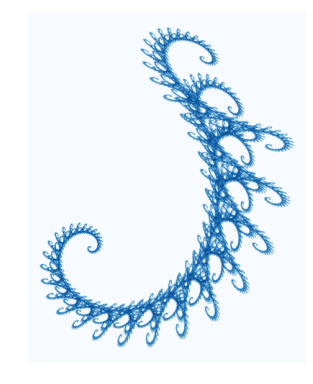

In [6]:
#%fig=使用IFS类绘制迭代函数系统
from scpy2.examples.fractal.ifs_demo import solve_eq, triangle_area
from scpy2.examples.fractal.fastfractal import IFS

triangles = np.array([        #❶
   [-1.945392491467576, -5.331010452961673],
   [6.109215017064848, -0.8710801393728236],
   [-1.1945392491467572, 5.400696864111497],
   [-2.5597269624573373, -4.21602787456446],
   [5.426621160409557, -2.125435540069687],
   [0.5119453924914676, 4.912891986062718],
   [3.5836177474402735, 8.397212543554005],
   [4.0614334470989775, 5.121951219512194],
   [8.56655290102389, 4.7038327526132395]])

base_triangle = triangles[:3]
triangle1 = triangles[3:6]
triangle2 = triangles[6:]

area1 = triangle_area(triangle1) #❷
area2 = triangle_area(triangle2)
total_area = area1 + area2
p = [area1 / total_area, area2 / total_area]

eq1 = solve_eq(base_triangle, triangle1) #❸
eq2 = solve_eq(base_triangle, triangle2)
eqs = np.vstack([eq1, eq2])

ifs = IFS(p, eqs, 2000000, size=600) #❹
counts = ifs.update()                #❺
print(("shape of counts:", counts.shape))
from matplotlib.colors import LogNorm
fig, ax = pl.subplots(figsize=(5, 8))
pl.imshow(counts, cmap="Blues", norm=LogNorm(), origin="lower") #❻
ax.axis("off");

### L-System分形

In [7]:
%%include python examples/fractal/lsystem_demo.py 1 -r
rules = [
    {
        "F":"F+F--F+F", "S":"F",
        "direct":180,
        "angle":60,
        "iter":5,
        "title":"Koch"
    },
    {
        "X":"X+YF+", "Y":"-FX-Y", "S":"FX",
        "direct":0,
        "angle":90,
        "iter":13,
        "title":"Dragon"
    },
    {
        "f":"F-f-F", "F":"f+F+f", "S":"f",
        "direct":0,
        "angle":60,
        "iter":7,
        "title":"Triangle"
    },
    {
        "X":"F-[[X]+X]+F[+FX]-X", "F":"FF", "S":"X",
        "direct":-45,
        "angle":25,
        "iter":6,
        "title":"Plant"
    }
    ,
    {
        "S":"X", "X":"-YF+XFX+FY-", "Y":"+XF-YFY-FX+",
        "direct":0,
        "angle":90,
        "iter":6,
        "title":"Hilbert"
    },
    {
        "S":"L--F--L--F", "L":"+R-F-R+", "R":"-L+F+L-",
        "direct":0,
        "angle":45,
        "iter":10,
        "title":"Sierpinski"
    },
]

In [8]:
%%include python examples/fractal/lsystem_demo.py 2 -r
class L_System(object):
    def __init__(self, rule):
        info = rule['S']
        for i in range(rule['iter']):
            ninfo = []
            for c in info:
                if c in rule:
                    ninfo.append(rule[c])
                else:
                    ninfo.append(c)
            info = "".join(ninfo)
        self.rule = rule
        self.info = info

    def get_lines(self):
        from math import sin, cos, pi
        d = self.rule['direct']
        a = self.rule['angle']
        p = (0.0, 0.0)
        l = 1.0
        lines = []
        stack = []
        for c in self.info:
            if c in "Ff":
                r = d * pi / 180
                t = p[0] + l*cos(r), p[1] + l*sin(r)
                lines.append(((p[0], p[1]), (t[0], t[1])))
                p = t
            elif c == "+":
                d += a
            elif c == "-":
                d -= a
            elif c == "[":
                stack.append((p,d))
            elif c == "]":
                p, d = stack[-1]
                del stack[-1]
        return lines

In [9]:
%%include python examples/fractal/lsystem_demo.py 3 -r
def draw(ax, rule, iter=None):
    from matplotlib import collections
    if iter!=None:
        rule["iter"] = iter
    lines = L_System(rule).get_lines() #❶
    linecollections = collections.LineCollection(lines, lw=0.7, color="black") #❷
    ax.add_collection(linecollections, autolim=True) #❸
    ax.axis("equal")
    ax.set_axis_off()
    ax.set_xlim(ax.dataLim.xmin, ax.dataLim.xmax)
    ax.invert_yaxis()

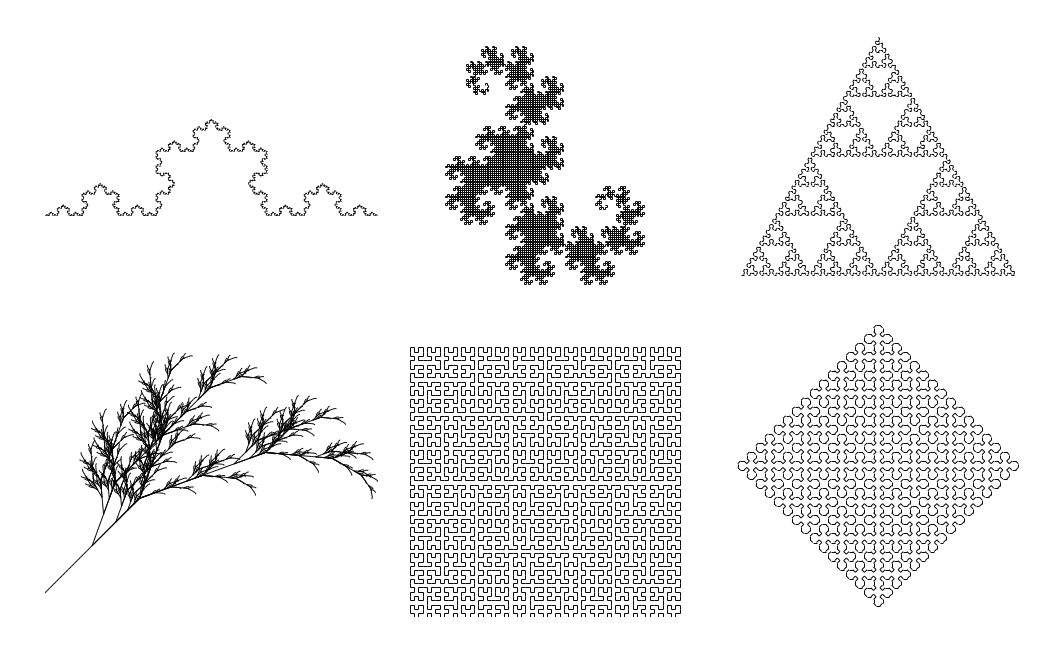

In [10]:
#%fig=几种L-System的迭代图案
%config InlineBackend.figure_format = 'png'
fig = pl.figure(figsize=(10, 6))
fig.patch.set_facecolor("w")

for i in xrange(6):
    ax = fig.add_subplot(231+i)
    draw(ax, rules[i])

fig.subplots_adjust(left=0,right=1,bottom=0,top=1,wspace=0,hspace=0)

### 分形山脉

#### 一维中点移位法

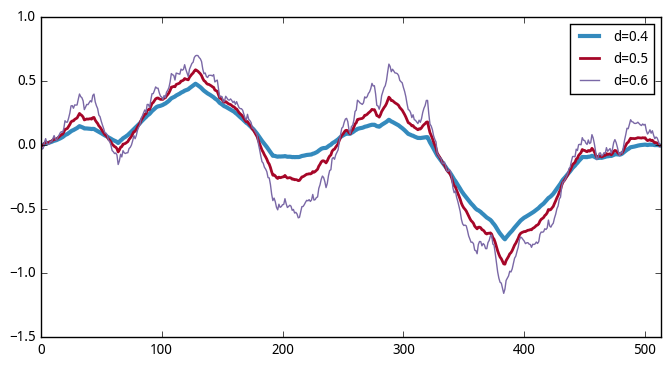

In [11]:
#%fig=一维分形山脉曲线，衰减值越小则最大幅度的衰减越快，曲线越平滑
def hill1d(n, d):
    """
    绘制山脉曲线，2**n+1为曲线在X轴上的长度，d为衰减系数
    """
    a = np.zeros(2**n+1) #❶
    scale = 1.0
    for i in range(n, 0, -1): #❷
        s = 2**(i-1) #❸
        s2 = 2*s
        tmp = a[::s2] 
        a[s::s2] += (tmp[:-1] + tmp[1:]) * 0.5 #❹
        a[s::s2] += np.random.normal(size=len(tmp)-1, scale=scale) #❺
        scale *= d #❻
    return a

pl.figure(figsize=(8,4))    
for i, d in enumerate([0.4, 0.5, 0.6]):
    np.random.seed(8) #❼
    a = hill1d(9, d)
    pl.plot(a, label="d=%s" % d, linewidth=3-i)   
pl.xlim(0, len(a))    
pl.legend();

#### 二维中点移位法

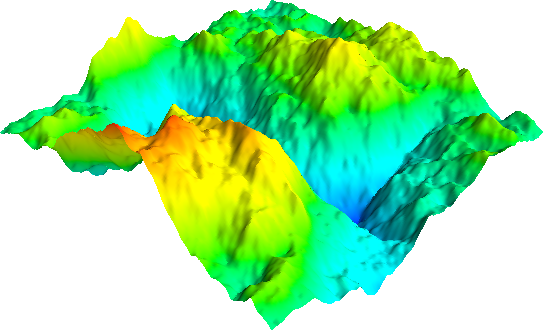

In [3]:
#%fig=二维中点移位法计算山脉曲面
def hill2d(n, d):
    """
    绘制山脉曲面，曲面是一个(2**n + 1)*(2**n + 1)的图像，
    d为衰减系数
    """
    from numpy.random import normal
    size = 2**n + 1
    scale = 1.0
    a = np.zeros((size, size))

    for i in xrange(n, 0, -1):
        s = 2**(i-1)
        s2 = s*2
        tmp = a[::s2,::s2]
        tmp1 = (tmp[1:,:] + tmp[:-1,:])*0.5 
        tmp2 = (tmp[:,1:] + tmp[:,:-1])*0.5
        tmp3 = (tmp1[:,1:] + tmp1[:,:-1])*0.5
        a[s::s2, ::s2] = tmp1 + normal(0, scale, tmp1.shape)
        a[::s2, s::s2] = tmp2 + normal(0, scale, tmp2.shape)
        a[s::s2,s::s2] = tmp3 + normal(0, scale, tmp3.shape)
        scale *= d

    return a

from scpy2 import vtk_scene_to_array
from mayavi import mlab
from scipy.ndimage.filters import convolve

np.random.seed(42)
a = hill2d(8, 0.5)
a/= np.ptp(a) / (0.5*2**8)        #❶
a = convolve(a, np.ones((3,3))/9) #❷

mlab.options.offscreen = True
scene = mlab.figure(size=(800, 600))
scene.scene.background = 1, 1, 1
mlab.surf(a)
img = vtk_scene_to_array(scene.scene)
%array_image img

#### 菱形方形算法

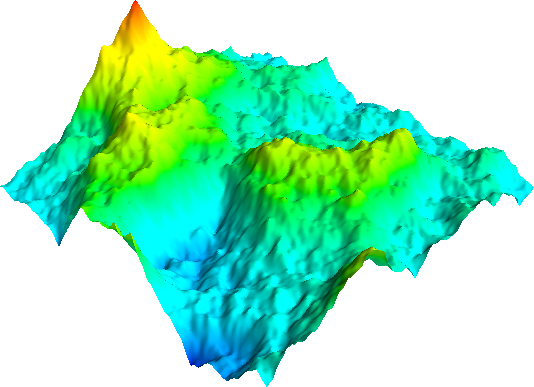

In [5]:
#%fig=使用菱形方形算法计算山脉曲面
def hill2d_ds(n, d):
    from numpy.random import normal
    size = 2**n + 1
    scale = 1.0
    a = np.zeros((size, size))

    for i in xrange(n, 0, -1):
        s = 2**(i-1)
        s2 = 2*s
        
        # 方形平均
        t = a[::s2,::s2]
        t2 = (t[:-1,:-1] + t[1:,1:] + t[1:,:-1] + t[:-1,1:])/4
        tmp = a[s::s2,s::s2]
        tmp[...] = t2 + normal(0, scale, tmp.shape)
        
        buf = a[::s2, ::s2]
        
        # 菱形平均分两步，分别计算水平和垂直方向上的点
        t = a[::s2,s::s2]
        t[...] = buf[:,:-1] + buf[:,1:]
        t[:-1] += tmp
        t[1:]  += tmp
        t[[0,-1],:] /= 3 # 边上是3个值的平均
        t[1:-1,:] /= 4 # 中间的是4个值的平均
        t[...] += np.random.normal(0, scale, t.shape)

        t = a[s::s2,::s2]    
        t[...] = buf[:-1,:] + buf[1:,:]
        t[:,:-1] += tmp
        t[:,1:] += tmp
        t[:,[0,-1]] /= 3
        t[:,1:-1] /= 4
        t[...] += np.random.normal(0, scale, t.shape)
    
        scale *= d
        
    return a

np.random.seed(42)
a = hill2d_ds(8, 0.5)
a/= np.ptp(a) / (0.5*2**8)        
a = convolve(a, np.ones((3,3))/9)

mlab.options.offscreen = True
scene = mlab.figure(size=(800, 600))
scene.scene.background = 1, 1, 1
mlab.surf(a)
img = vtk_scene_to_array(scene.scene)
%array_image img